RECORDAR DESZIPEAR PROPERATTI.ZIP

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
import seaborn as sns

In [4]:
data = pd.read_csv("..\properatti.csv", index_col=0)
data.shape

(121220, 25)

In [40]:
data.dtypes

operation                      object
property_type                  object
place_name                     object
place_with_parent_names        object
country_name                   object
state_name                     object
geonames_id                   float64
lat-lon                        object
lat                           float64
lon                           float64
price                         float64
currency                       object
price_aprox_local_currency    float64
price_aprox_usd               float64
surface_total_in_m2           float64
surface_covered_in_m2         float64
price_usd_per_m2              float64
price_per_m2                  float64
floor                         float64
rooms                         float64
expenses                      float64
properati_url                  object
description                    object
title                          object
image_thumbnail                object
dtype: object

In [41]:
data.rooms.value_counts()

3.0     12567
2.0     12433
4.0      7937
1.0      7377
5.0      3782
6.0      1403
7.0       770
8.0       409
10.0      226
9.0       184
11.0       72
12.0       65
13.0       33
14.0       27
15.0       26
17.0       16
16.0       11
20.0       11
22.0        8
18.0        6
21.0        5
30.0        4
25.0        4
19.0        4
32.0        3
23.0        2
24.0        1
27.0        1
29.0        1
31.0        1
28.0        1
Name: rooms, dtype: int64

In [5]:
#ver la descripcion de la columna rooms
print(data["rooms"].info())
print("__________________________")
print("Cantidad de datos nulos: ", data["rooms"].isnull().sum())

<class 'pandas.core.series.Series'>
Int64Index: 121220 entries, 0 to 121219
Series name: rooms
Non-Null Count  Dtype  
--------------  -----  
47390 non-null  float64
dtypes: float64(1)
memory usage: 1.8 MB
None
__________________________
Cantidad de datos nulos:  73830


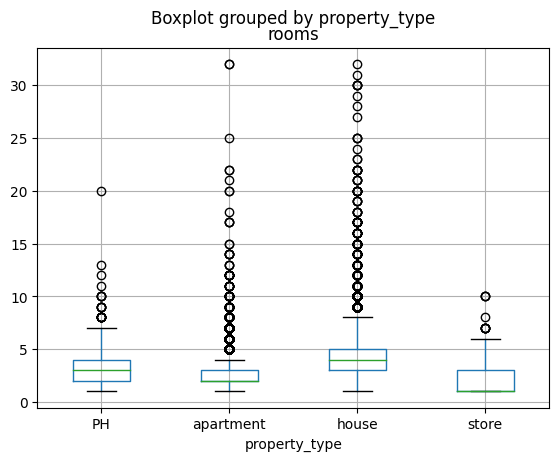

In [9]:
#visualizando la dispersion de rooms y floor
data.boxplot(column= "rooms", by="property_type") 
#data.boxplot(column = "floor", by="property_type")
plt.show()

In [10]:
mask_residencial= data.property_type != 'store'
tipos_residenciales=data.property_type[mask_residencial]
rooms_residenciales=data.rooms[mask_residencial]
df_residencial=pd.DataFrame(tipos_residenciales)
df_residencial['rooms']=rooms_residenciales

##### Intentamos ver si los datos faltantes de rooms disminuyen si descontamos las tiendas

In [11]:
shape_df=df_residencial.shape
count_res=shape_df[0]


In [12]:
nulos_room=df_residencial.rooms.isna().sum(axis=0)
pctje_nulos_rooms=nulos_room/count_res
pctje_nulos_rooms

0.5961446482867001

Veamos cuantas rooms tienen las tiendas

In [45]:
mask_comercial= data.property_type == 'store'
tipos_comerciales=data.property_type[mask_comercial]
rooms_comerciales=data.rooms[mask_comercial]
df_comercial=pd.DataFrame(tipos_comerciales)
df_comercial['rooms']=rooms_comerciales
df_comercial.rooms.value_counts()

1.0     55
2.0     17
3.0     13
7.0      6
5.0      4
4.0      4
10.0     3
6.0      2
8.0      1
Name: rooms, dtype: int64

#### Recordemos que el porcentaje original de nulos era similar, 

Veamos si los faltantes de expensas disminuyen sacando tiendas y casas

In [46]:
mascara_sin_casas=df_residencial.property_type !='house'
expensas_residenciales=data.expenses[mask_residencial]
df_residencial['expenses']=expensas_residenciales
expensas_deps_ph=expensas_residenciales[mascara_sin_casas]
null_exp_clean=expensas_deps_ph.isnull().sum()
shape_exp_clean=expensas_deps_ph.shape
pctje_null_exp_clean=null_exp_clean/shape_exp_clean[0]
pctje_null_exp_clean
type_deps_ph=df_residencial.property_type[mascara_sin_casas]
type_deps_ph.value_counts()

apartment    71065
PH            5751
Name: property_type, dtype: int64

In [47]:
expensas_deps_ph.isnull().sum()/expensas_deps_ph.shape[0]

0.8496146636117475

Probemos ahora sacando los nulos de rooms para tratar de aplicar un promedio del tamaño de las rooms

In [48]:
mask_rooms_no_nulas=data.rooms.notnull()
rooms_no_nulas=data.rooms.loc[mask_rooms_no_nulas]
sf_room_no_nulas=data.surface_covered_in_m2.loc[mask_rooms_no_nulas]
df_rooms_clean=pd.DataFrame(rooms_no_nulas)
df_rooms_clean['m2_covered']=sf_room_no_nulas
mask_rooms_no_nulas.value_counts()

False    73830
True     47390
Name: rooms, dtype: int64

In [49]:
m2_nulos_rooms_clean=df_rooms_clean.m2_covered.isnull().sum()
shape_rooms_clean=df_rooms_clean.shape
pctje_nulos_rooms_clean=m2_nulos_rooms_clean/shape_rooms_clean[0]
pctje_nulos_rooms_clean

0.12789618062882466

Determinar la tasa de cambio utilizada

In [13]:

tasa_cambio = data['price_aprox_local_currency'] / data['price_aprox_usd']
tasa_cambio.unique()
#aqui vemos que aparecen datos diferentes por los decimales,entonces vamos a redondear a 2 decimales 

array([17.6445    ,         nan, 17.64449974, ..., 17.64449995,
       17.64449998, 17.64449994])

In [14]:
print(tasa_cambio.round(2).unique())
print(tasa_cambio.isna().sum())

[17.64   nan]
20411


El pctje de m2 cubiertos es ligeramente menor, por lo que no hay mucha correlacion entre nulidad de rooms y nulidad de m2_covered
Hay que inputar los m2 cubiertos faltantes antes de poder avanzar a tener un promedio de cuantos m2 tiene cada habitación
Para imputar las rooms, me imagino hay que inputar promedio por tipo de propiedad, hace falta por barrio, o alguna caracteristica extra?? Para mi no hace falta.

### Veamos el tema de los m2 faltantes

Primera cosa a tener en cuenta, los m2 covered tienen un pctje nulo del 16% y los totales tienen un pctje del 32%
Price_per_m2 tiene un faltante del 28%
Price usd per m2 tiene un faltante del 43%
Todos las variantes de precios totales tienen un faltante aprox del 17%